#### Import data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

data = pd.read_csv("../data/historical_weather.csv")

# rename columns to readable names
data.rename(columns={
  "temperature_2m_max (°C)": "max_temp",
  "temperature_2m_min (°C)": "min_temp",
  "temperature_2m_mean (°C)": "mean_temp",
  "precipitation_sum (mm)": "precipitation"
}, inplace=True)

# set time to datetime and index it
data["time"] = pd.to_datetime(data["time"])
data.set_index("time", inplace=True)

# resample data to yearly data
data = data.resample('A-DEC').mean()

# remove columns not to be predicted by model
data = data[["mean_temp"]]

#### Generate dates to predict

In [3]:
# generate dates to predict (dates after 2023)
start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2050, 12, 31)

dates = []
current_date = start_date
while current_date <= end_date:
  dates.append(current_date.strftime("%Y-%m-%d"))
  current_date += datetime.timedelta(days=1)

# convert dates to dataframe
dates_to_predict = pd.DataFrame(dates, columns=["time"])

#### Train model and Predict temperatures

In [4]:
# 9,1,12 are the best params after playing a bit with them
model = ARIMA(data, order=(9,2,12))

model_fit = model.fit()
predictions = model_fit.predict(start="2023-01-01",end="2050-12-31")

# add noise to prediction
noise_level = 0.4
random_noise = np.random.normal(0, noise_level, len(predictions))

noisy_predictions = predictions + random_noise

predictions_df = pd.DataFrame(noisy_predictions)
predictions_df.rename(columns={
  "predicted_mean": "mean_temp"
}, inplace=True)

/home/favo/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/favo/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/favo/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Visualize prediction

#### Visualize past data (1940-2022)

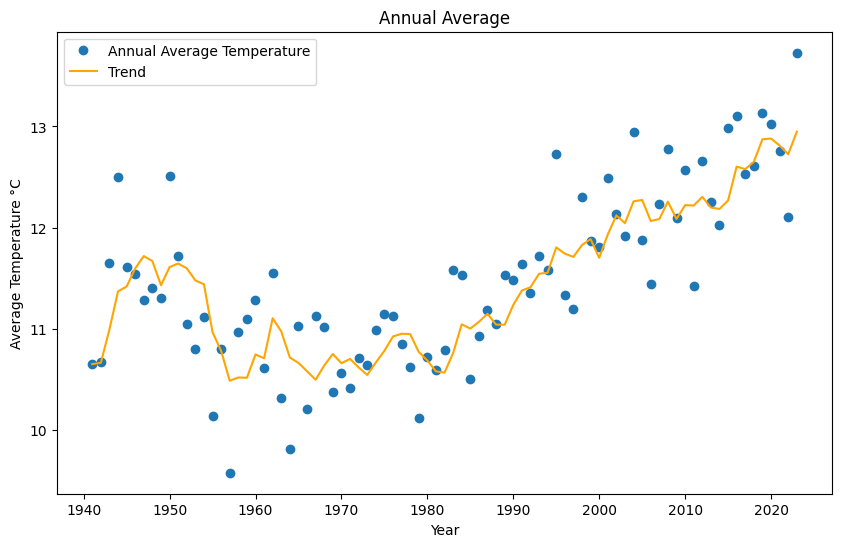

In [5]:
annual_average = data["mean_temp"].resample("Y").mean()
trend_line = annual_average.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(
  annual_average.index,
  annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none"
)
plt.plot(
  trend_line.index,
  trend_line.values,
  color="orange",
  label="Trend"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

#### Visualize future (predicted) data (2023-2050)

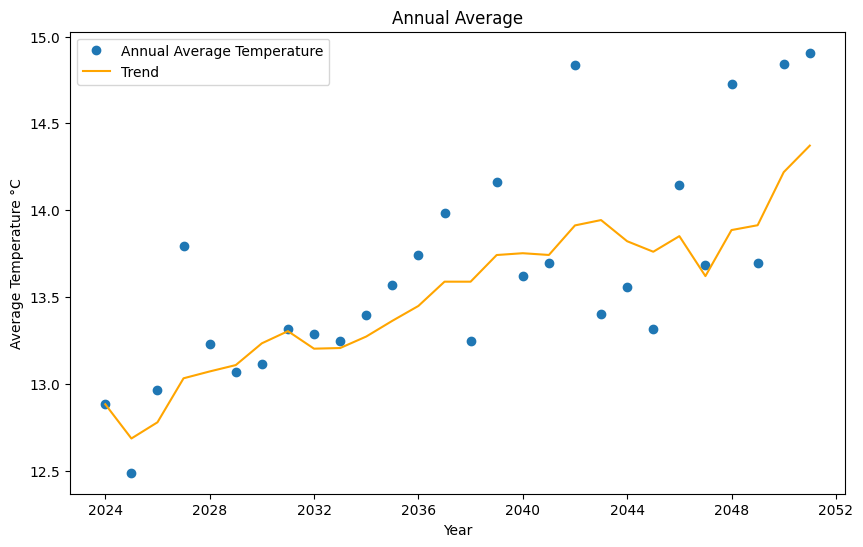

In [6]:
# predictions_df["time"] = pd.to_datetime(predictions_df["time"])
# predictions_df.set_index("time", inplace=True)

future_annual_average = predictions_df["mean_temp"].resample("Y").mean()
future_trend_line = future_annual_average.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(
  future_annual_average.index,
  future_annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none"
)
plt.plot(
  future_trend_line.index,
  future_trend_line.values,
  color="orange",
  label="Trend"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

#### Visualize past and future data

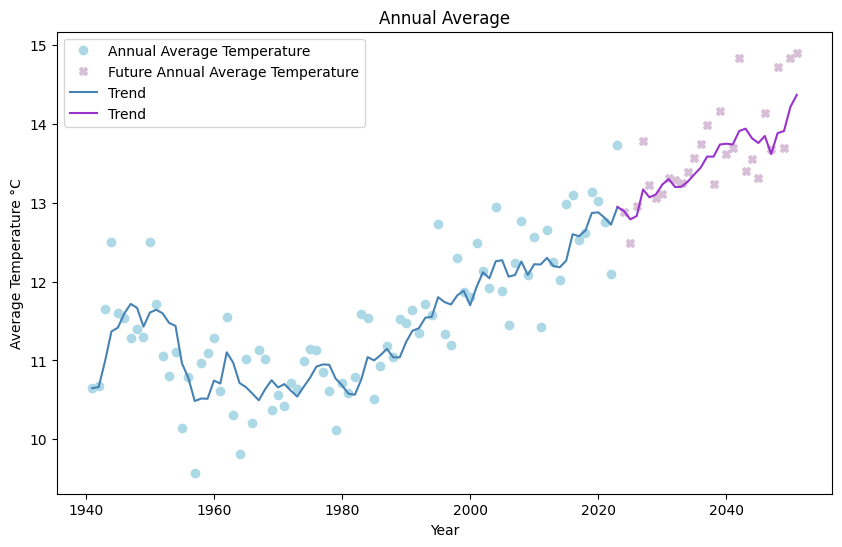

In [7]:
# common trend line
common_average = pd.concat([annual_average, future_annual_average])

common_trend_line = common_average.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
# past temps
plt.plot(
  annual_average.index,
  annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none",
  color="lightblue"
)
# future temps
plt.plot(
  future_annual_average.index,
  future_annual_average.values,
  label="Future Annual Average Temperature",
  marker="X",
  linestyle="none",
  color="thistle"
)
# past trend
plt.plot(
  common_trend_line[:"2022-12-31"].index,
  common_trend_line[:"2022-12-31"].values,
  label="Trend",
  color="steelblue"
)
# future trend
plt.plot(
  common_trend_line["2022-12-31":].index,
  common_trend_line["2022-12-31":].values,
  label="Trend",
  color="darkorchid"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

#### Compare prediction with prediction by EGO institute

Data used: EC_Earth3P_HR by European Geosciences Union

In [8]:
ego_data = pd.read_csv("../data/climate_change.csv")

# rename columns to readable names
ego_data.rename(columns={
  "temperature_2m_max (°C)": "max_temp",
  "temperature_2m_min (°C)": "min_temp",
  "temperature_2m_mean (°C)": "mean_temp",
  "precipitation_sum (mm)": "precipitation"
}, inplace=True)

# set time to datetime and index it
ego_data["time"] = pd.to_datetime(ego_data["time"])
ego_data.set_index("time", inplace=True)

# resample data to yearly data
ego_data = ego_data.resample('A-DEC').mean()

# remove columns not to be predicted by model
ego_data = ego_data[["mean_temp"]]

ego_data = ego_data["2023-01-01":]

#### Visualize EGO future predictions

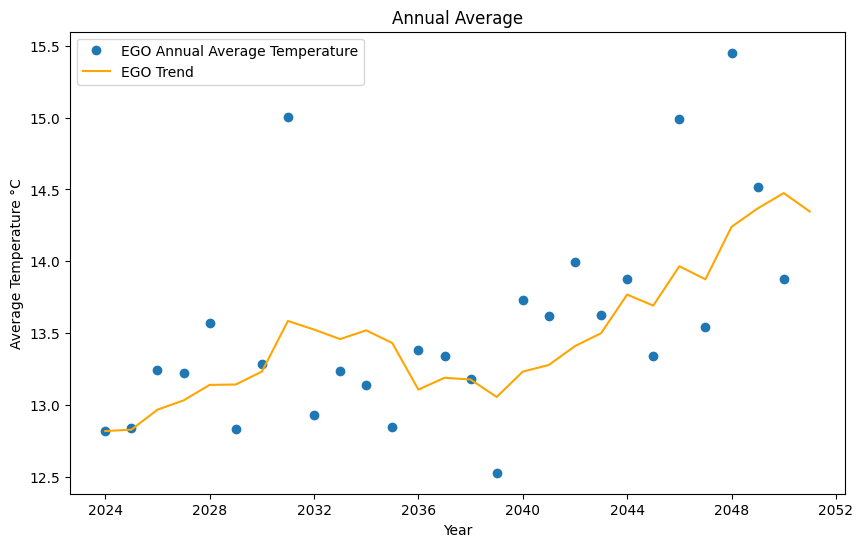

In [9]:
ego_trend_line = ego_data.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(
  ego_data.index,
  ego_data.values,
  marker="o",
  label="EGO Annual Average Temperature",
  linestyle="none"
)
plt.plot(
  ego_trend_line.index,
  ego_trend_line.values,
  color="orange",
  label="EGO Trend"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

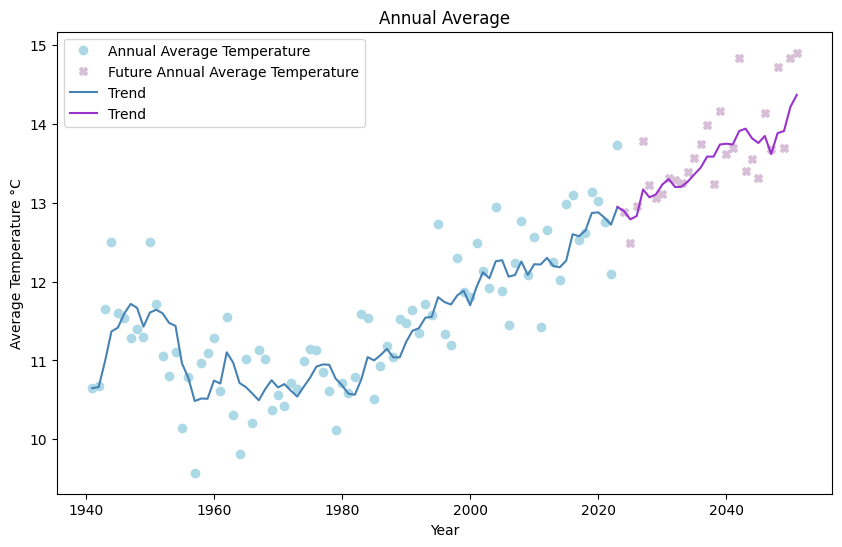

In [10]:
# common trend line
common_average = pd.concat([annual_average, future_annual_average])

common_trend_line = common_average.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
# past temps
plt.plot(
  annual_average.index,
  annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none",
  color="lightblue"
)
# future temps
plt.plot(
  future_annual_average.index,
  future_annual_average.values,
  label="Future Annual Average Temperature",
  marker="X",
  linestyle="none",
  color="thistle"
)
# past trend
plt.plot(
  common_trend_line[:"2022-12-31"].index,
  common_trend_line[:"2022-12-31"].values,
  label="Trend",
  color="steelblue"
)
# future trend
plt.plot(
  common_trend_line["2022-12-31":].index,
  common_trend_line["2022-12-31":].values,
  label="Trend",
  color="darkorchid"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()

#### Compare EGO with our prediction

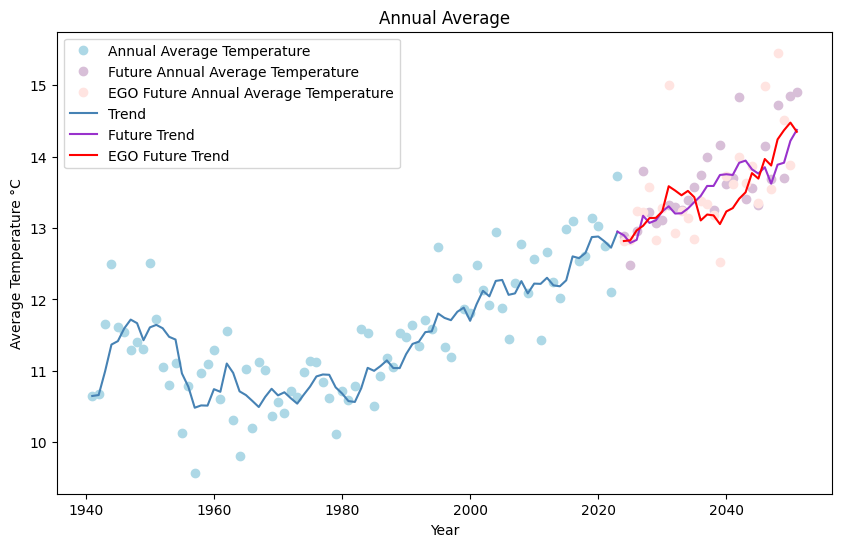

In [11]:
# common trend line
common_average = pd.concat([annual_average, future_annual_average])

common_trend_line = common_average.rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(10, 6))
# past temps
plt.plot(
  annual_average.index,
  annual_average.values,
  marker="o",
  label="Annual Average Temperature",
  linestyle="none",
  color="lightblue"
)
# future temps
plt.plot(
  future_annual_average.index,
  future_annual_average.values,
  label="Future Annual Average Temperature",
  marker="o",
  linestyle="none",
  color="thistle"
)
# ego future temps
plt.plot(
  ego_data.index,
  ego_data.values,
  label="EGO Future Annual Average Temperature",
  marker="o",
  linestyle="none",
  color="mistyrose"
)
# past trend
plt.plot(
  common_trend_line[:"2022-12-31"].index,
  common_trend_line[:"2022-12-31"].values,
  label="Trend",
  color="steelblue"
)
# future trend
plt.plot(
  common_trend_line["2022-12-31":].index,
  common_trend_line["2022-12-31":].values,
  label="Future Trend",
  color="darkorchid"
)
# ego future trend
plt.plot(
  ego_trend_line.index,
  ego_trend_line.values,
  label="EGO Future Trend",
  color="red"
)
plt.xlabel("Year")
plt.ylabel("Average Temperature °C")
plt.title("Annual Average")
plt.legend()
plt.show()